1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.1.0
    Uninstalling setuptools-67.1.0:
      Successfully uninstalled setuptools-67.1.0


### Setup kaggle API key

In [2]:
# create the .kaggle directory
!mkdir -p ~/.kaggle

# create an empty kaggle.json file
!touch ~/.kaggle/kaggle.json

# change permission so only owner has read and write access
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# edit the kaggle.json file to have username name and api token

import json
kaggle_username = "everylittlething"
kaggle_key = "############################"

with open("/home/studio-lab-user/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download the dataset

In [4]:
# download the dataset
!kaggle competitions download -c bike-sharing-demand

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# unzip the dataset
!unzip -o bike-sharing-demand.zip

Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


#### import the necessary modules

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from autogluon.tabular import TabularPredictor


### Create the training and testing dataset

In [7]:
train = pd.read_csv("train.csv", parse_dates = ["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
#verify the dtype of the datetime column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
test = pd.read_csv("test.csv", parse_dates = ["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [11]:
# drop the registered and casual columns as they are not included in the test dataset
train.drop(labels =['casual', 'registered'], axis = 'columns', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [12]:
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Training my first AutoGluon Model

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
initial_predictor = TabularPredictor(label = "count", eval_metric="root_mean_squared_error").fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)


No path specified. Models will be saved in: "AutogluonModels/ag-20230208_190524/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_190524/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feat

### Review and Visulaize Performance of Models

In [14]:
initial_results = initial_predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.965566      10.567992  278.983268                0.000614           0.367440            3       True         20
1   NeuralNetFastAI_BAG_L2  -52.232990       9.481580  260.307134                0.358563          36.681585            2       True         17
2   RandomForestMSE_BAG_L2  -53.420655       9.669647  237.849257                0.546630          14.223708            2       True         14
3     ExtraTreesMSE_BAG_L2  -53.852866       9.662184  227.710536                0.539167           4.084987            2       True         16
4           XGBoost_BAG_L2  -54.809633       9.249479  234.099637                0.126462          10.474088            2       True         18
5          LightGBM_BAG_L2  -55.227345       9.310986  232.090122         

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


<AxesSubplot: xlabel='model'>

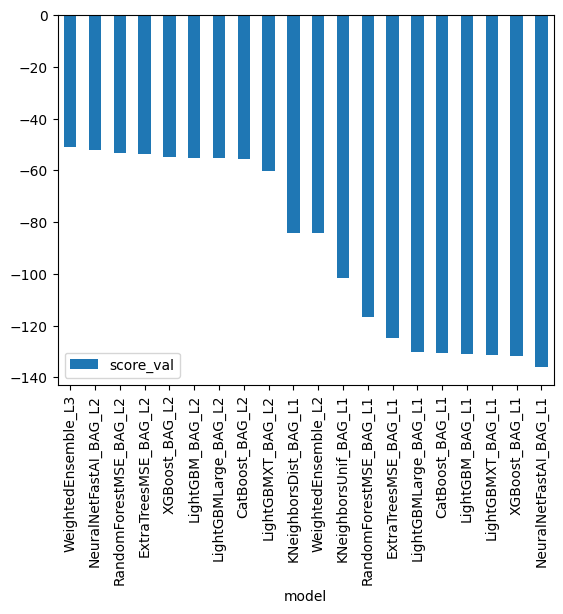

In [15]:
initial_predictor.leaderboard(silent=True).plot(kind = "bar", x="model", y= "score_val")

### Create predictions from test dataset to submit to kaggle

In [16]:
predictions = initial_predictor.predict(test)
predictions.head()

0    25.323147
1    40.703457
2    45.163582
3    47.924675
4    50.777081
Name: count, dtype: float32

In [17]:
#remove any negative values, as they are not allowed. replace negative values with zero
(predictions < 0).sum()

0

In [18]:
def replaceNegative(x):
    if x < 0:
        return 0
    return x

In [19]:
predictions.apply(replaceNegative)
(predictions < 0).sum()

0

In [20]:
submission['count'] = predictions
submission.to_csv("submission.csv", index=False)

#### Submit submissions.cvs

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 209kB/s]
Successfully submitted to Bike Sharing Demand

#### Review initial score

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                       date                 description                                                      status    publicScore  privateScore  
-----------------------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission.csv                 2023-02-08 19:19:27  first raw submission                                             complete  1.81150      1.81150       
submission_hpo_numbagsets.csv  2023-02-06 22:42:23  with features num_bag_sets hyperparameter set to 10              complete  0.53768      0.53768       
submission_hpo_autostack.csv   2023-02-06 22:32:02  with features autostack hyperparameter turned on                 complete  0.71450      0.71450       
submission_new_features.csv    2023-02-06 21:47:55  second sunmission-with additional features-with datetime column  complete  0.71051      0.71051       


In [23]:
initial_score = 1.81150

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot: title={'center': 'datetime'}>,
        <AxesSubplot: title={'center': 'season'}>,
        <AxesSubplot: title={'center': 'holiday'}>],
       [<AxesSubplot: title={'center': 'workingday'}>,
        <AxesSubplot: title={'center': 'weather'}>,
        <AxesSubplot: title={'center': 'temp'}>],
       [<AxesSubplot: title={'center': 'atemp'}>,
        <AxesSubplot: title={'center': 'humidity'}>,
        <AxesSubplot: title={'center': 'windspeed'}>],
       [<AxesSubplot: title={'center': 'count'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

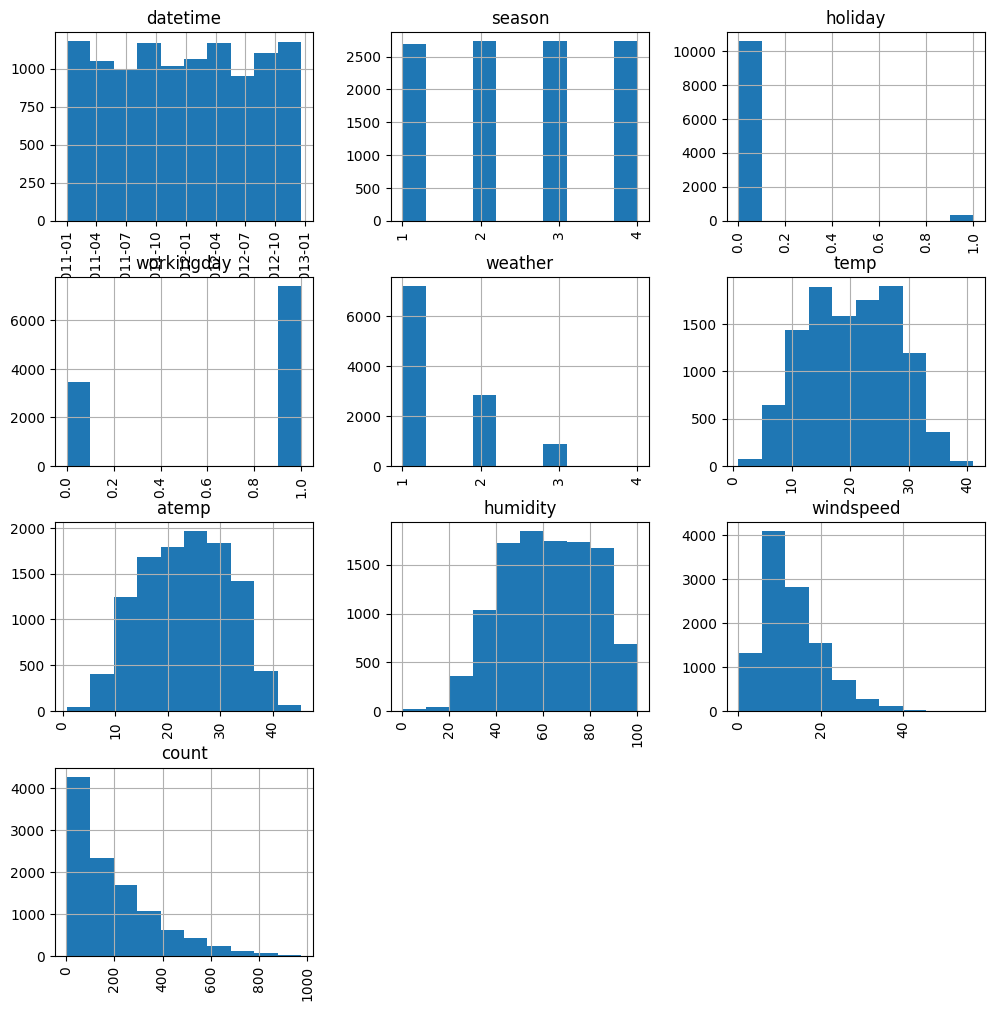

In [24]:
train.hist(figsize=(12,12), xrot = 90)

In [25]:
# create hour day and month feature
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [26]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  month       10886 non-null  int64         
 11  day         10886 non-null  int64         
 12  hour        10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(7)
memory usage: 957.3 KB


In [28]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,1,1,4


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
 9   month       6493 non-null   int64         
 10  day         6493 non-null   int64         
 11  hour        6493 non-null   int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(6)
memory usage: 520.5 KB


In [30]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,20,4


array([[<AxesSubplot: title={'center': 'datetime'}>,
        <AxesSubplot: title={'center': 'holiday'}>,
        <AxesSubplot: title={'center': 'workingday'}>],
       [<AxesSubplot: title={'center': 'temp'}>,
        <AxesSubplot: title={'center': 'atemp'}>,
        <AxesSubplot: title={'center': 'humidity'}>],
       [<AxesSubplot: title={'center': 'windspeed'}>,
        <AxesSubplot: title={'center': 'count'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'day'}>,
        <AxesSubplot: title={'center': 'hour'}>, <AxesSubplot: >]],
      dtype=object)

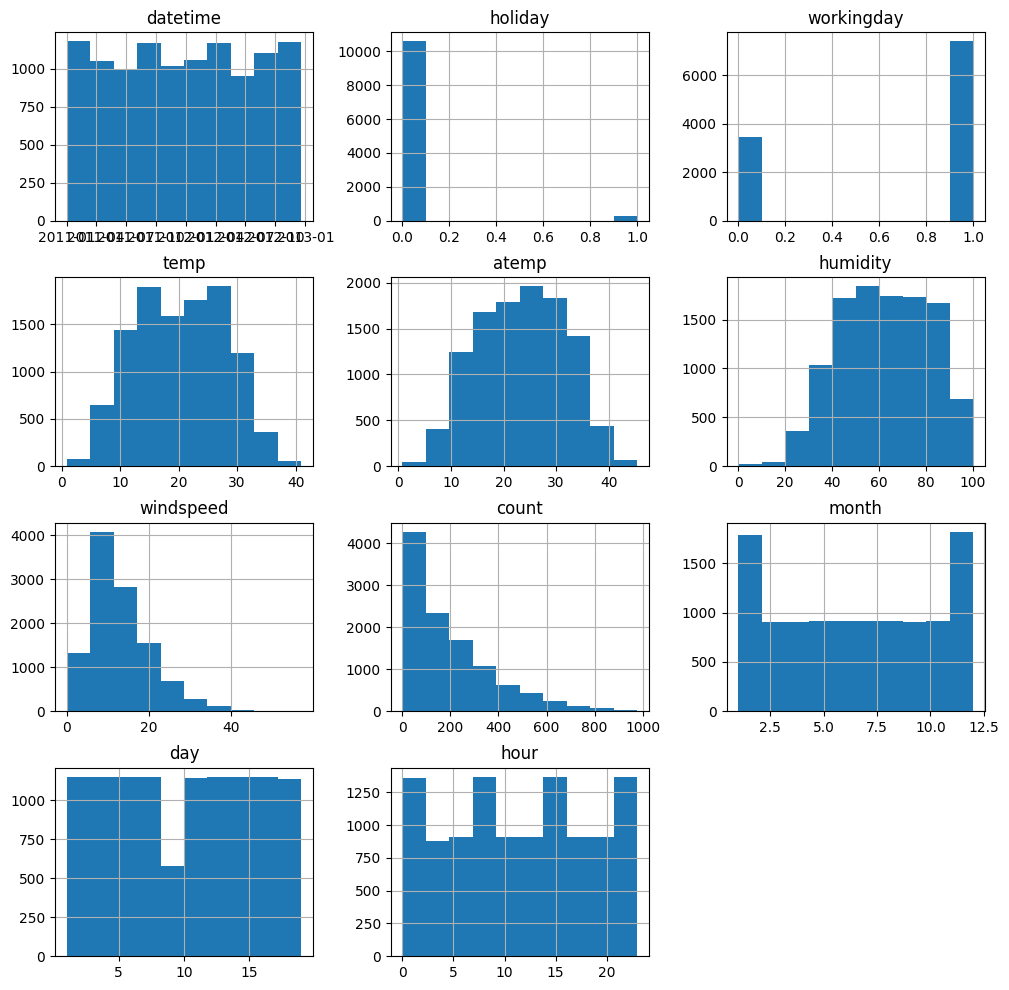

In [31]:
train.hist(figsize=(12,12))

## Step 5: Rerun the model with the same settings as before, just with more features

In [32]:
predictor_new_features = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230208_192013/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_192013/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [33]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.519450      16.463303  521.682012                0.000638           0.380157            3       True         19
1   NeuralNetFastAI_BAG_L2  -29.835508      15.876106  424.703304                0.408815          40.017958            2       True         16
2          CatBoost_BAG_L2  -30.562221      15.583987  460.097621                0.116695          75.412276            2       True         14
3          LightGBM_BAG_L2  -30.614619      15.698038  393.743757                0.230747           9.058412            2       True         12
4           XGBoost_BAG_L2  -30.946871      15.706409  396.813209                0.239118          12.127864            2       True         17
5        LightGBMXT_BAG_L2  -31.187054      16.252877  396.379498         

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'Weig

<AxesSubplot: xlabel='model'>

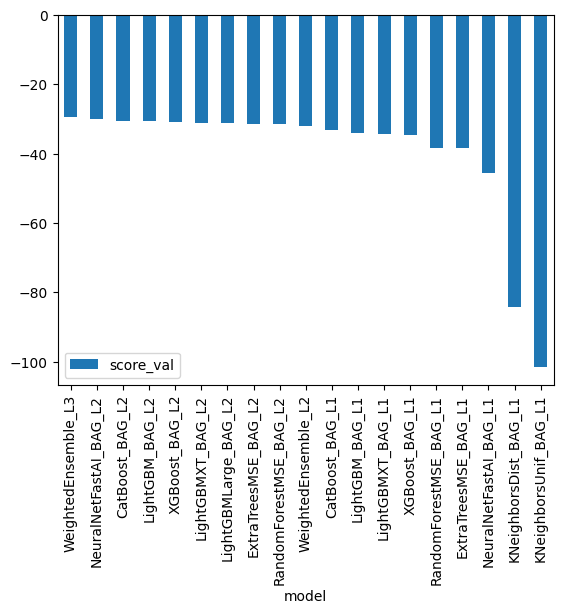

In [34]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

### Make predictions on the test data using the new predictor

In [35]:
predictions_new_features = predictor_new_features.predict(test)

In [36]:
print((predictions_new_features < 0).sum())
# remove any negative values
predictions_new_features = predictions_new_features.apply(replaceNegative)
print((predictions_new_features < 0).sum())

8
0


### Sumbit predictions using new features

In [37]:
submission_new_features = submission

In [38]:
submission_new_features['count'] = predictions_new_features
submission_new_features.to_csv('submission_new_features.csv', index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "second sunmission-with additional features-with datetime column"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 307kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                       date                 description                                                      status    publicScore  privateScore  
-----------------------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission_new_features.csv    2023-02-08 19:31:36  second sunmission-with additional features-with datetime column  complete  0.73379      0.73379       
submission.csv                 2023-02-08 19:19:27  first raw submission                                             complete  1.81150      1.81150       
submission_hpo_numbagsets.csv  2023-02-06 22:42:23  with features num_bag_sets hyperparameter set to 10              complete  0.53768      0.53768       
submission_hpo_autostack.csv   2023-02-06 22:32:02  with features autostack hyperparameter turned on                 complete  0.71450      0.71450       


##### new score with additional features = 0.73379


## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

Hyperparameter 1: Turn on autostack

In [41]:
predictor_hpo_autostack = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230208_193217/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_193217/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [42]:
predictor_hpo_autostack.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.503920      16.408429  531.028608                0.000872           0.331122            3       True         17
1   NeuralNetFastAI_BAG_L2  -29.853909      15.887228  423.355840                0.429833          38.563317            2       True         16
2          CatBoost_BAG_L2  -30.354574      15.557079  481.413835                0.099684          96.621311            2       True         14
3          LightGBM_BAG_L2  -30.613571      15.878039  395.512858                0.420644          10.720335            2       True         12
4        LightGBMXT_BAG_L2  -31.123882      16.612890  399.016638                1.155495          14.224114            2       True         11
5     ExtraTreesMSE_BAG_L2  -31.306565      16.011533  389.388230         

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.546199084

<AxesSubplot: xlabel='model'>

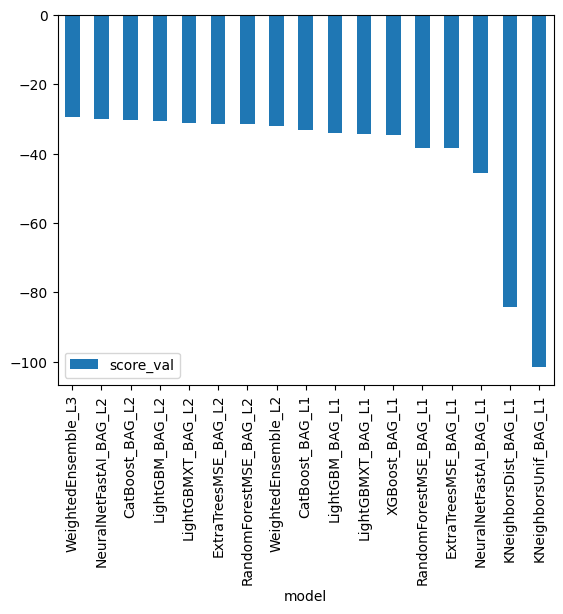

In [43]:
predictor_hpo_autostack.leaderboard(silent=True).plot(kind='bar', x= 'model', y='score_val')

In [44]:
predictions_autostack = predictor_hpo_autostack.predict(test)

In [45]:
predictions_autostack = predictions_autostack.apply(replaceNegative)

In [46]:
submission_hpo_autostack = submission

In [47]:
submission_hpo_autostack['count'] = predictions_autostack
submission_hpo_autostack.to_csv('submission_hpo_autostack.csv', index=False)

In [48]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_autostack.csv -m "with features autostack hyperparameter turned on"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 263kB/s]
Successfully submitted to Bike Sharing Demand

In [49]:
#hyperparameter1 score: 

Hyperparameter 2: set num_bag_sets to 10

In [50]:
predictor_hpo_numbagsets = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    num_bag_sets = 10
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230208_194408/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=10
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_194408/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [51]:
predictor_hpo_numbagsets.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.510473      16.488574  515.595163                0.000674           0.379608            3       True         19
1   NeuralNetFastAI_BAG_L2  -29.829871      15.702436  423.697258                0.394386          38.927491            2       True         16
2          CatBoost_BAG_L2  -30.380834      15.400216  440.812574                0.092166          56.042807            2       True         14
3          LightGBM_BAG_L2  -30.597311      15.516460  393.544284                0.208410           8.774517            2       True         12
4           XGBoost_BAG_L2  -30.989411      15.465101  395.065372                0.157051          10.295605            2       True         17
5     LightGBMLarge_BAG_L2  -31.204465      15.635888  401.175135         

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'Weig

<AxesSubplot: xlabel='model'>

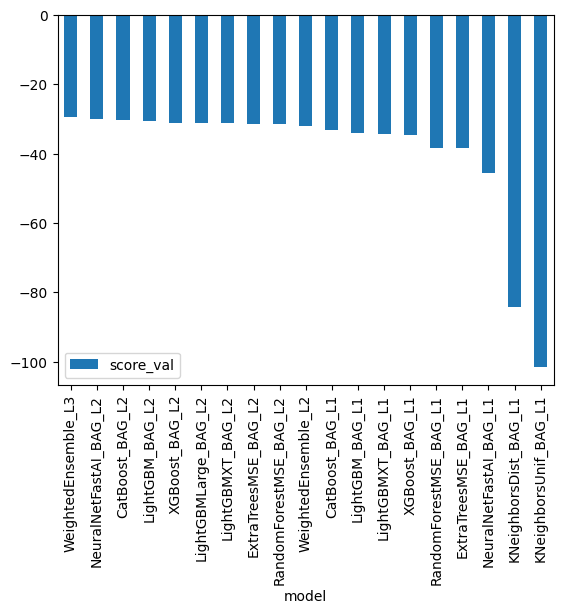

In [52]:
predictor_hpo_numbagsets.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [53]:
predictions_numbagsets = predictor_hpo_numbagsets.predict(test)

In [54]:
predictions_numbagsets = predictions_numbagsets.apply(replaceNegative)

In [55]:
submission_hpo_numbagsets = submission

In [56]:
submission_hpo_numbagsets['count'] = predictions_numbagsets
submission_hpo_numbagsets.to_csv('submission_hpo_numbagsets.csv', index=False)

In [57]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_numbagsets.csv -m "with features num_bag_sets hyperparameter set to 10"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 265kB/s]
Successfully submitted to Bike Sharing Demand

In [58]:
predictor_hpo_both = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True,
    num_bag_sets = 10
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230208_200056/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=10
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_200056/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [59]:
predictor_hpo_both.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.507298      16.402308  524.007218                0.000632           0.451353            3       True         19
1   NeuralNetFastAI_BAG_L2  -29.836338      15.886761  423.993260                0.384541          39.023146            2       True         16
2          CatBoost_BAG_L2  -30.423970      15.592390  464.808463                0.090170          79.838348            2       True         14
3          LightGBM_BAG_L2  -30.638280      15.720599  393.747753                0.218379           8.777639            2       True         12
4           XGBoost_BAG_L2  -30.873065      15.708585  395.916733                0.206365          10.946619            2       True         17
5        LightGBMXT_BAG_L2  -31.252795      16.341062  396.321493         

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'Weig

<AxesSubplot: xlabel='model'>

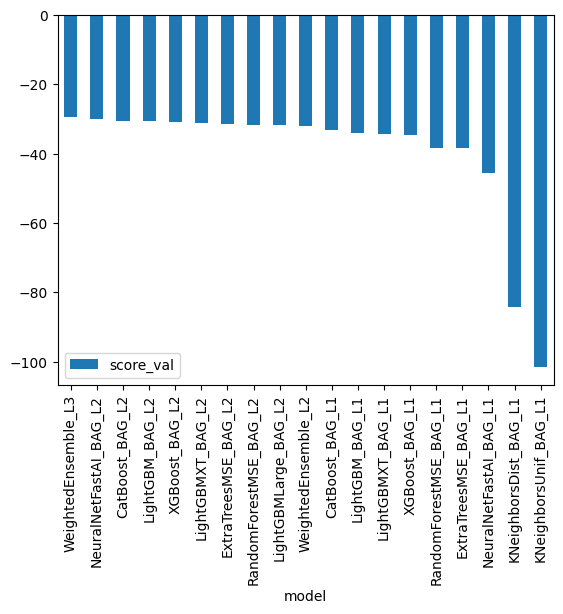

In [60]:
predictor_hpo_both.leaderboard(silent=True).plot(kind='bar', x = 'model', y= 'score_val')

In [61]:
predictions_both = predictor_hpo_both.predict(test)

In [62]:
predictions_both = predictions_both.apply(replaceNegative)

In [63]:
submission_hpo_both = submission

In [64]:
submission_hpo_both['count'] = predictions_both
submission_hpo_both.to_csv('submission_hpo_both.csv', index=False)

In [65]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_both.csv -m "with features autostack turned on and num_bag_sets set to 10"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 307kB/s]
Successfully submitted to Bike Sharing Demand

In [66]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 15

fileName                       date                 description                                                      status    publicScore  privateScore  
-----------------------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission_hpo_both.csv        2023-02-08 20:12:36  with features autostack turned on and num_bag_sets set to 10     complete  0.74653      0.74653       
submission_hpo_numbagsets.csv  2023-02-08 20:00:50  with features num_bag_sets hyperparameter set to 10              complete  0.73910      0.73910       
submission_hpo_autostack.csv   2023-02-08 19:43:44  with features autostack hyperparameter turned on                 complete  0.76628      0.76628       
submission_new_features.csv    2023-02-08 19:31:36  second sunmission-with additional features-with datetime column  complete  0.73379      0.73379       
submission.csv                 2023-02-08 19:19:27  first raw submissi

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [67]:
kaggle_scores = pd.DataFrame(
    {
        "Training run": ["Without added features", "With added features", "Autostack on","Num_bag_sets=10", "Autostack, num_bag_sets"],
        "Kaggle score": [1.73373, 0.76168, 0.70008, 0.72921, 0.71271]
    })

/tmp/ipykernel_76/2837081484.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(kaggle_scores['Training run'],rotation=90)


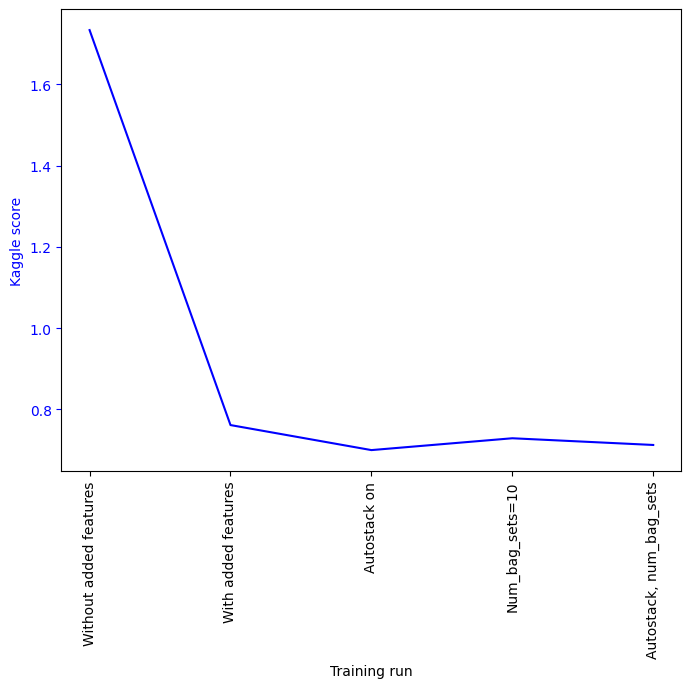

In [69]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(kaggle_scores["Training run"], kaggle_scores['Kaggle score'], color='blue')
ax.set_xticklabels(kaggle_scores['Training run'],rotation=90)
ax.set_xlabel('Training run')
ax.set_ylabel('Kaggle score', color='blue')
ax.tick_params('y', colors='blue')

In [70]:
fig.savefig('model_kaggle_score.png')

In [71]:
#the. most performant model in all training runs ws the WeightedEnsemble_l3
model_eval_metric = pd.DataFrame(
    {
        "Training run": ["Without added features", "With added features", "Autostack on","Num_bag_sets=10", "Autostack, num_bag_sets"],
        "Evaluation metric score": [-50.999267, -29.272368, -30.241311, -30.121382, -30.118559]
    }
)

In [73]:
ax2 = ax.twinx()
ax2.plot(model_eval_metric[ "Training run"], model_eval_metric["Evaluation metric score"], color='red')
ax2.set_ylabel("Evaluation metric score", color='red')
ax2.tick_params('y',colors='red')
plt.show()


In [74]:
#bbox_inches ='tight' ensures all elements of the figure fits within the image
fig.savefig('evalmetric_kaggle_score.png', bbox_inches='tight')

In [75]:
summary_df = pd.concat([kaggle_scores, model_eval_metric['Evaluation metric score']], axis=1, join='inner')
summary_df

,Training run,Kaggle score,Evaluation metric score
0,Without added features,1.73373,-50.999267
1,With added features,0.76168,-29.272368
2,Autostack on,0.70008,-30.241311
3,Num_bag_sets=10,0.72921,-30.121382
4,"Autostack, num_bag_sets",0.71271,-30.118559


In [76]:
summary_df.to_csv('summary_table.csv', index=False)

### Perform log transform on count data

<AxesSubplot: >

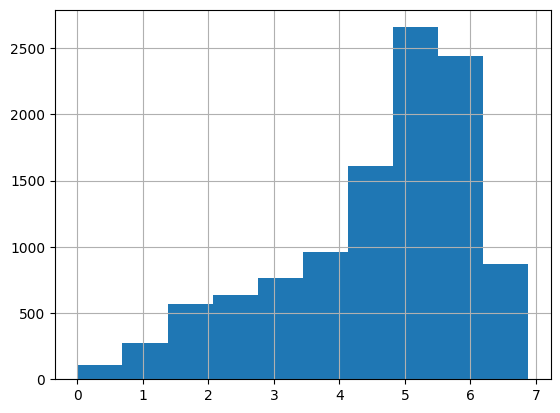

In [77]:
log_count = np.log(train['count'])
log_count.hist()

<AxesSubplot: >

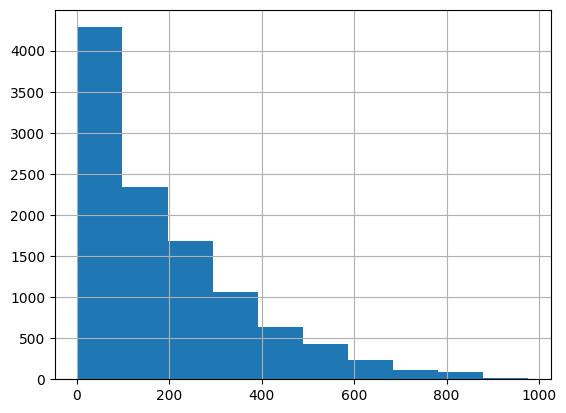

In [78]:
train['count'].hist()

In [79]:
train_ln_transform = train
train_ln_transform['count'] = log_count

#### since we achieved the best score with autostack on, let's try this setting on the ln transform of the count label

In [80]:
predictor_transform_autostack = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(
    train_data = train_ln_transform,
    time_limit = 600,
    presets = "best_quality",
    auto_stack = True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230208_201500/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230208_201500/"
AutoGluon Version:  0.6.1
Python Version:     3.9.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (6.884486652042782, 0.0, 4.55256, 1.48904)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regressio

In [81]:
predictor_transform_autostack.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.273514       8.011729  467.101207                0.000638           0.369104            3       True         21
1   NeuralNetFastAI_BAG_L2  -0.275204       7.745889  407.112952                0.469090          38.736659            2       True         18
2          CatBoost_BAG_L2  -0.280792       7.364996  418.578414                0.088197          50.202121            2       True         16
3          LightGBM_BAG_L2  -0.281049       7.453806  377.793324                0.177007           9.417031            2       True         14
4      WeightedEnsemble_L2  -0.284674       6.386200  326.933346                0.000660           0.495103            2       True         12
5     ExtraTreesMSE_BAG_L2  -0.284992       7.846265  373.202330                

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

<AxesSubplot: xlabel='model'>

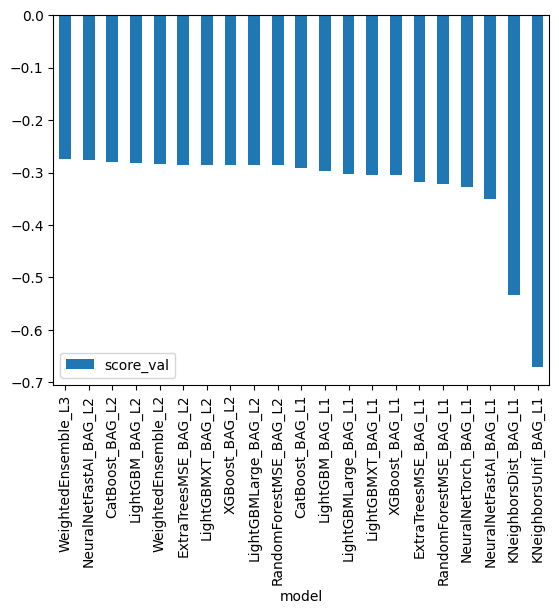

In [82]:
predictor_transform_autostack.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [83]:
test_transform = predictor_transform_autostack.predict(test)

In [84]:
#exponentiate count to undo ln transform
test_transform = np.exp(test_transform)

In [85]:
#make submission file
submission_transform = submission
submission_transform['count'] = test_transform
submission_transform.to_csv('submission_transform.csv',index=False)


In [86]:
#submit to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_transform.csv -m "with features, autostack on, ln transform of count"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 223kB/s]
Successfully submitted to Bike Sharing Demand

In [88]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 15

fileName                       date                 description                                                      status    publicScore  privateScore  
-----------------------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission_transform.csv       2023-02-08 20:25:18  with features, autostack on, ln transform of count               complete  0.66348      0.66348       
submission_hpo_both.csv        2023-02-08 20:12:36  with features autostack turned on and num_bag_sets set to 10     complete  0.74653      0.74653       
submission_hpo_numbagsets.csv  2023-02-08 20:00:50  with features num_bag_sets hyperparameter set to 10              complete  0.73910      0.73910       
submission_hpo_autostack.csv   2023-02-08 19:43:44  with features autostack hyperparameter turned on                 complete  0.76628      0.76628       
submission_new_features.csv    2023-02-08 19:31:36  second sunmission-

kaggle score after performing ln transform: 0.66348